In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.patches import Circle
from matplotlib.patches import Wedge
from mpl_toolkits.mplot3d import Axes3D
import datetime as dt
from bfields import *
from efields import *
from plottools import *
from boris import *
# from unhcolors import *

import pymms.data
from pymms.data import util, edi, fpi, anc
from pymms.sdc import mrmms_sdc_api as api


# Use %matplotlib notebook to change to a zoom-able display.
%matplotlib inline

# Distribution Plots based on Menz et al. 2019, Fig. 4

## Step 0.1 Constants

In [3]:
RE = 6371000    # radius of earth [m] 
mp = 1.6e-27    # proton mass [kg]
me = 9.1e-31    # electron mass [kg]
qe = 1.603E-19  # proton charge [C]

# creating charged particle / particle packet
m = mp*4
q = qe*2

# other constants and constraints
kp = 8.5        # kp index
gs = 2.0        # shielding constant

## Step 0.2 Select time of MMS orbit, load data

In [4]:
# Find apogee and perigee to determine an inbound or outbound leg of the orbit
#   - Take t0 as the time of interest
#   - Orbital periods are roughly 3 days
#   - The time interval has to encompass at least one entire orbit for the search to return anything

t0 = dt.datetime(2020, 6, 29, 0)
t_start = t0 - dt.timedelta(days=2)
t_end = t0 + dt.timedelta(days=2) # dt.datetime(2020, 6, 29, 12)

# An orbit begins at perigee. Determine apogee and perigee for this orbit (i.e. outbound time interval)
#   - An inbound time interval would be apogee for this orbit and perigee for the next orbit
orbits = api.mission_events('orbit', t_start, t_end, sc='mms1')
orbit = orbits['start_orbit'][0]

# Get the apogee and perigee times
t_perigee = api.mission_events('perigee', orbit, orbit, sc='mms1')['tstart'][0]
t_apogee = api.mission_events('apogee', orbit, orbit, sc='mms1')['tstart'][0]

# load mms data for timeframe
r_vname = '_'.join(('mms1', 'mec', 'r', 'gse'))
mec_data = util.load_data(sc='mms1', 
                        instr='mec', mode='srvy', 
                        level='l2', optdesc='epht89d', 
                        start_date=t_perigee, 
                        end_date=t_apogee, 
                        variables=r_vname)

print('Perigee: ', t_perigee)
print('Apogee:  ', t_apogee)

Perigee:  2020-06-27 01:54:48
Apogee:   2020-06-28 19:49:16


## Step 1. Fetch the position of MMS on inbound leg of orbit from Perigee to Apogee

In [44]:

# get mms position values in [km] and convert to array in units [m]
pos = mec_data['mms1_mec_r_gse'].data*1.e3

# convert position to units [RE]
posRE = pos/RE

# check
# print(posRE)
    

In [45]:
# trim data to exclude initial positions >rmax

# upper boundary 
rmax = 10

# array to hold indices to remove from data
rm_indices = []

rmag = np.sqrt(np.sum(posRE**2, axis=1))
i_lt_rmax = np.argwhere(rmag <= 10).squeeze()
pos = pos[i_lt_rmax, :]
posRE = posRE[i_lt_rmax, :]

'''
# collect initial pos. that is over boundary rmax
for count, val in enumerate(pos):
    rmag = mag(val)/RE
    if rmag >= rmax:
        rm_indices.append(count)
        
# remove elements from array         
pos = np.delete(pos, rm_indices, 0)
posRE = np.delete(posRE, rm_indices, 0)
#vdat = np.delete(vdat, rm_indices, 0)
'''

print(posRE)

[[ 1.52844296  1.40591412 -0.19808009]
 [ 1.51312023  1.42595385 -0.17354249]
 [ 1.49756646  1.44577597 -0.14897834]
 ...
 [-8.21676912 -0.63999393  5.61055637]
 [-8.22789079 -0.64716573  5.61393668]
 [-8.23900107 -0.65433651  5.61730915]]


## Step 2. Find energy bins

In [56]:
# function to get components of velocity
def get_vcomponents(energy, mass, theta, phi):
    
    # velcoity magnitude 
    vmag = np.sqrt(2*energy*(1/mass))
    
    # velocity components [UNITS]
    vx = vmag*np.sin(theta)*np.cos(phi)
    vy = vmag*np.sin(theta)*np.sin(phi)
    vz = vmag*np.cos(theta)
    
    return np.stack([vx,vy,vz], axis=1)

In [22]:
# pull dataset
dis_data = fpi.load_dist(sc='mms1', mode='srvy', optdesc='dis-dist', start_date=t_perigee, end_date=t_apogee)

In [57]:
# get energy bins at initial time in units [eV]
ebins = dis_data['energy'][0].data

# convert to [J]
ebins = ebins*1.602176e-19

# get angle data
phidat = dis_data['phi'].data
thetadat = dis_data['theta'].data

# find velocity magnetiude [m/s]
#vmag_mms = [np.sqrt(2*i/mp) for i in ebin0]
#vbins = [get_vcomponents(e0, m, )]

# for i in range(0,32):
#     vol[i] = get_vcomponents(ebins[i], m, thetadat[3], phidat[3])
vol = get_vcomponents(ebins, m, thetadat[3], phidat[3])
volRE = vol / RE # convert units to [RE/s]
    
# note: There are 32 energy bins, but 16 angle (theta, phi) values, not sure how to go about this
#       so currently all inital angles are the same.

# check
# print(vol)

## Step 3. For each position, launch 32 particles, one for each energy, and trace backwards for ~11 hours (40000s).

According to Menz (2019) Fig. 4, the drift time should range from 1 hr (3600s) to 10 hrs (36000s)

In [209]:
import importlib as imp
import boris
imp.reload(boris)
from boris import *

In [ ]:
tf = 0.1*3600    # duration time (code will run for this exact time, regardless if L=10 crossed or not)
dt = 0.01       # timestep

# inital parameters
rdat_mms = posRE[[0,-1],:]  # intial position (see Step 1.)
vdat_mms = volRE[[16,],:]  # intial velocity (see Step 2.)

# fake data (ignore)
# rdat_mms = np.random.uniform(low=1, high=8., size=(7,3))*RE
# vdat_mms = np.random.uniform(low=-4., high=4., size=(10,3))
v0_test = np.array([0.,0.,0.])

nstep = len(rdat_mms)*len(vdat_mms)

lshell_dat = np.zeros(nstep)
tdrift_dat = np.zeros(nstep)
energy_dat = np.zeros(nstep)

r_final = []
t_final = []
count = 0

for r0 in rdat_mms:
    for v0 in vdat_mms:
        print('{0} of {1}'.format(count, nstep))
        tdat, tdrift, vdat, rdat, emag = boris(tf, r0, v0, m, q, gs, kp,
                                               tdir='bw', rmax=10, dn_save=1, dt_wci=0.005)
        r_final.append(rdat)
        t_final.append(tdat)
        """
        boris.py output key:
        
        tdat (ndarray): time data in units [s]
        tdrift (ndarray): drift time in units [s]
        vdat (ndarray): velocity data in units [m/s]
        rdat (ndarray): position data in units [m]
        emag (ndarray): magnitude of total E-field in units [mV/m]
        """
        # collect drfit time
        tdrift_dat[count] = tdrift 
        
        # find initial L-shell [RE]
        lshell = mag(r0)/RE
        
        #print('lshell = ', lshell)
        
        # find inital energy [J]
        enval = 0.5*m*mag(v0)**2
        
        # convert energy to keV
        enval = enval*6.242e+15
        
        # append data to arrays
        lshell_dat[count] = lshell
        energy_dat[count] = enval
        
        # print dirft time in units [hr]
        # count incrmenet
        count += 1

print("Max drift time found: ", max(tdrift_dat))

0 of 2
Run time: 360.0, Time step: 0.0001849087383583739, Steps: 1946906


  0%|          | 0/1946905 [00:00<?, ?it/s]

> /Users/argall/Documents/Python/imef/particle-tracing/boris-tracing/boris.py(167)boris()
-> if ((i+1) % dn_save) == 0:
(Pdb) rnew
array([ 1.52844296,  1.40591412, -0.19808009])
(Pdb) rdat[0]
array([ 1.52844296,  1.40591412, -0.19808009])
(Pdb) vnew
array([ 0.00886489, -0.02083396, -0.00235545])
(Pdb) rnew
array([ 1.52844296,  1.40591412, -0.19808009])
(Pdb) vnew*dt
array([ 1.63919539e-06, -3.85238140e-06, -4.35542984e-07])
(Pdb) type(vnew)
<class 'numpy.ndarray'>
(Pdb) vnew.dtype
dtype('float64')


## Plots

### Volland-Stern and Corotation Potentials

In [152]:
# plot of the convective electric field with the rotation electric field and over plotting the last closed drift 
'''
constants
'''
gs      = 2.0       # shielding constant
RE      = 6371000   # radius of earth [m] 
lmax    = 10        # max L-shell level (L) to be calculated
mltmax  = 24        # max magnetic local time (MLT)

# convert to radial geo and theta

rmax = lmax*RE                  # rdist(lmax, mltmax)
pmax = mltmax*15*(np.pi/180)    # max angle
dr   = 300 

# create coordinate grids

rn = np.linspace(RE, rmax, dr)
pn = np.linspace(0., pmax, dr)

r, phi = np.meshgrid(rn, pn)


ln = np.linspace(0, lmax, dr)
mn = np.linspace(0.0, mltmax, dr)

l, mlt = np.meshgrid(ln, mn)




# arrays to hold data

emap_new = np.zeros(r.shape)   # convection E-field 
umap_new = np.zeros(r.shape)   # potential 
etot_new = np.zeros(r.shape)   # total E-field (convection and corotation)
utot_new = np.zeros(r.shape)   # total potential (convection and corotation)

# compute field values
for i in range(0,dr):
    for j in range(0,dr):
        
        r0 = r[i,j]
        p0 = phi[i,j]
        coords = np.array([r0, np.pi/2., p0])
        
        # calculations

        EC = vs_efield(coords, gs, kp, sph = True)      # convection E-field [mV/m]
        ER = corotation_efield(coords, sph = True)      # corotation E-field [mV/m]
        UC = vs_potential(coords, gs, kp, sph = True)   # convection potential [kV]
        UR = corotation_potential(coords, sph = True)   # corotation potential [kV]
        

        emap_new[i,j] = mag(EC)
        umap_new[i,j] = UC
        etot_new[i,j] = mag(EC+ER)
        utot_new[i,j] = UC+UR
        
        # test
        # print(UR, utot_new[i,j])
        # print(f"(i,j): ({i},{j}) | coords: {round(r0,2)} | UC: {round(UC,2)} | UR: {round(UR,2)} | SUM: {UR+UC} | utot = {utot_new[i,j]} ")


# remove unwanted datapoints within 1RE, where Earth is
bad = np.where(r < RE)
emap_new[bad] = np.nan

### Last Closed Equipotential

In [110]:
LCE = get_LCE(phi, utot_new, pn, dr)

### Spherical Coordinates

In [106]:
def cart2sph(x_ijk):
    r_ijk = np.zeros_like(x_ijk)
    r_ijk[:,0] = np.sqrt(np.sum(x_ijk**2, axis=1))
    r_ijk[:,1] = np.arccos(x_ijk[:,2] / r_ijk[:,0])
    r_ijk[:,2] = np.arctan2(x_ijk[:,1], x_ijk[:,0])
    return r_ijk

In [99]:
def sph2cart(r_ijk):
    x_ijk = np.zeros_like(r_ijk)
    x_ijk[:,0] = r_ijk[:,0] * np.sin(r_ijk[:,1]) * np.cos(r_ijk[:,2])
    x_ijk[:,1] = r_ijk[:,0] * np.sin(r_ijk[:,1]) * np.sin(r_ijk[:,2])
    x_ijk[:,2] = r_ijk[:,0] * np.cos(r_ijk[:,1])
    return x_ijk

In [174]:
# MMS position
r_mms_sphr = cart2sph(posRE)

# Particle positions
r_part_sphr = [cart2sph(r) for r in r_final]

In [ ]:
'''
# convert mms position cartesian coords to spherical coords
rdat_sph = np.zeros((len(posRE), 3))
for i in range(0, len(posRE)):
    rdat_sph[i] = np.array(crt_to_sph(posRE[i][0], posRE[i][1],posRE[i][2]))

rdat_rad = rdat_sph[:, 0]
rdat_theta = rdat_sph[:, 1]
rdat_phi = rdat_sph[:, 2]
'''

### Plot

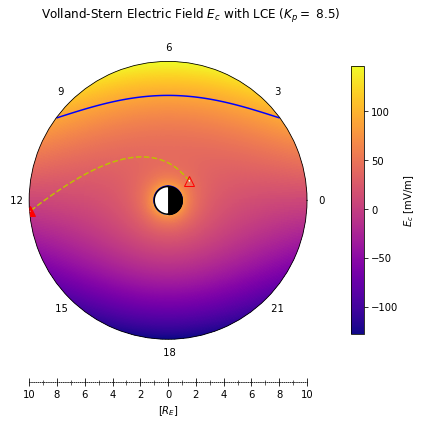

In [185]:
'''
plot of volland-stern convection electric and potential
'''
# scale coordinates in units [RE] 
rscale = r/RE

fig, axes = plt.subplots(nrows=1, ncols=1, squeeze=False, subplot_kw=dict(projection='polar'), figsize=(6, 6))
ax1 = axes[0, 0]
ax1.grid(False)

# draw the earth
draw_earth(ax1, polar=True, style=False, zorder=10)

# set title
fig.suptitle(f"Volland-Stern Electric Field $E_c$ with LCE ($K_p =$ {kp})", y = 0.95)

# A/N: standard figsize, use y=1.05 in 'suptitle' and no fraction in 'colorbar'

# Plot Potential
uplot = ax1.pcolormesh(phi, rscale, utot_new, shading='nearest', cmap='plasma')
fig.colorbar(uplot, ax=ax1, pad=0.13, fraction=0.04, label="$E_c$ [mV/m]")

# scale angular by MLT
scale_ang = ticker.FuncFormatter(lambda phi, pos: '{0: .0f}'.format(math.degrees(phi/15)))
ax1.xaxis.set_major_formatter(scale_ang)

# hide radial labels
ax1.set_yticklabels([])

# RE-scaled subaxis 
add_offscale_RE(ax1, 10, half=False)

# compute and plot LCE
LCE_plot = ax1.contour(phi, rscale, utot_new, [LCE], colors='b', linestyles='solid')

# plot the part of the MMS orbit that you're using 
mms_path = ax1.plot(r_mms_sphr[:,2], r_mms_sphr[:,0], 'y--',zorder=5)
mms_start = ax1.plot(r_mms_sphr[0,2], r_mms_sphr[0,0], 'r^', zorder=5, markersize=10, markerfacecolor='none')
mms_end = ax1.plot(r_mms_sphr[-1,2], r_mms_sphr[-1,0], 'r^', zorder=5, markersize=10)

# Plot the drift of the first and last particle
p1_path = ax1.plot(r_part_sphr[0][:,2], r_part_sphr[0][:,0], color='1.0', linestyle=':' ,zorder=100)
p2_path = ax1.plot(r_part_sphr[1][:,2], r_part_sphr[1][:,0], color='0.75', linestyle=':' ,zorder=5)

plt.show()

tdat = 0.0
* drift time: 0.0029429139730621167 hrs
* Initial position: (1.5284429639884811, 1.4059141155537607, -0.1980800869224619) RE
* Initial vel|ocity: (3.0, -1.0, 3.0) m/s
* Duration: 40000 s (666.67 min.)
* E-field: 2.89e-07 mV/m (mean), 3.93e+00 mV/m (max), 0.00e+00 mV/m (min) 


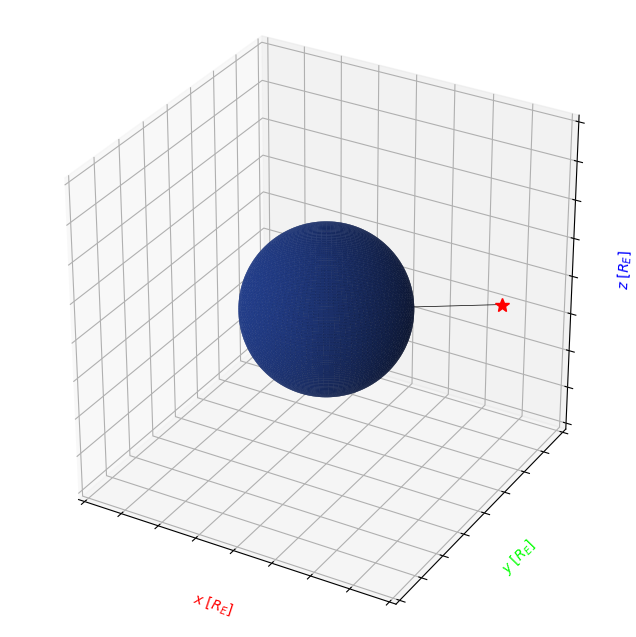

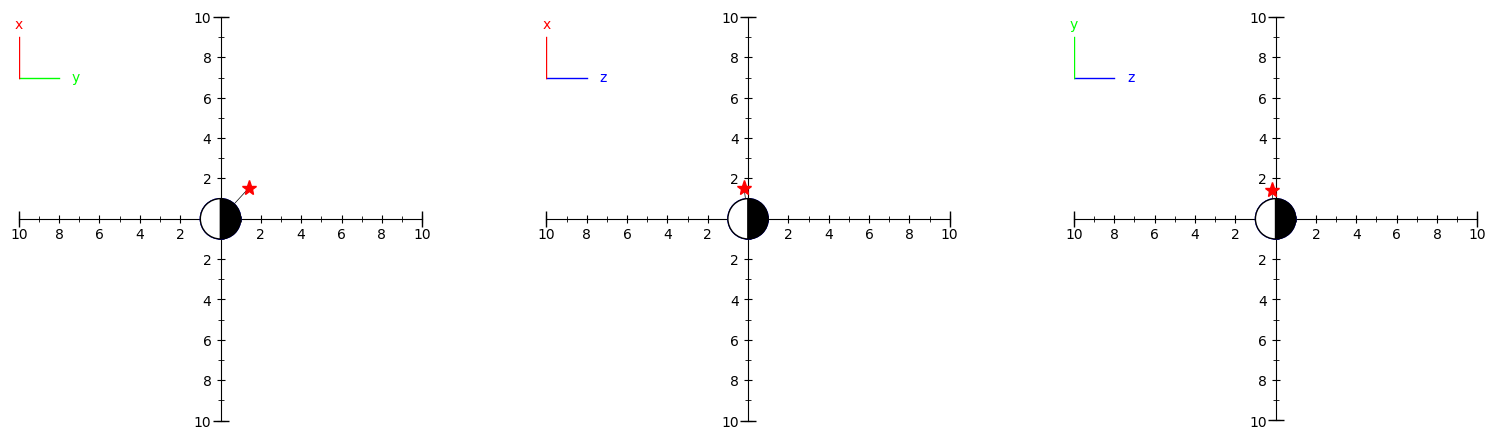

In [ ]:
# boris drift path of the first and last particle from selected mms orbit
tf = 40000      # duration time (code will run for this exact time, regardless if L=10 crossed or not)
dt = 0.01       # tiemstep

# set initial conditions                            
r0 = pos[0]
v0 = np.array([3.,-1.,3.])

tdat, tdrift, vdat, rdat, emag = boris(tf, r0, v0, m, q, gs, kp, tdir="bw")

# scale coordinates in units [RE]  
rscale = rdat/RE

tracingplot_3d(rdat)
tracingplot_2d(rdat)


# diagnostic data
print(f'* drift time: {tdrift} hrs')
print(f'* Initial position: {rscale[0][0], rscale[0][1], rscale[0][2]} RE')
print(f'* Initial vel|ocity: {vdat[0][0], vdat[0][1], vdat[0][2]} m/s')
print(f'* Duration: {tf} s ({round(tf/60,2)} min.)')
print(f'* E-field: {np.mean(emag):.2e} mV/m (mean), {max(emag):.2e} mV/m (max), {min(emag):.2e} mV/m (min) ')

plt.show() 




In [ ]:
pos[0]

array([ 9737710.12357061,  8957078.83019301, -1261968.233783  ])

# IGNORE EVERYHTHING BELOW

In [ ]:
x=np.argwhere(np.isnan(tdrift_dat))
tdrift

0.23751318448900594

In [ ]:
for i in range (0, len(tdrift_dat)-1):
   x = tdrift_dat[i+1]-tdrift_dat[i]
   print(x)


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-4.899941410613142e-06
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-5.2669426143688025e-06
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-5.59792791796597e-06
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-5.886911756716219e-06
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-6.1284808605941744e-06
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-6.318074267738175e-06
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0

In [ ]:
tdrift_dat[100]-tdrift_dat[166]

1.2015392617310394e-05

## Plot

ValueError: not enough values to unpack (expected 2, got 1)

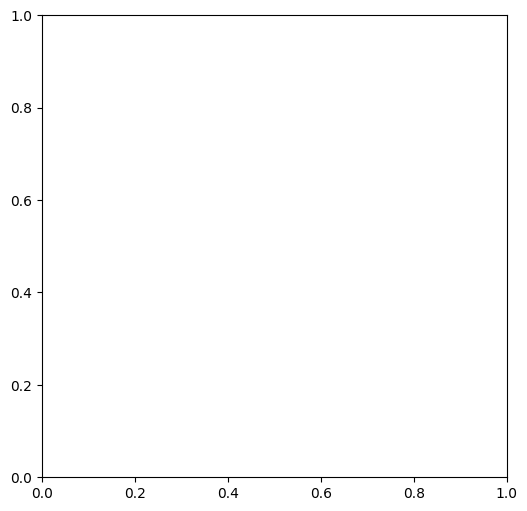

In [ ]:
# scale coordinates in units [RE] 
# rscale = lshell_dat/RE

# scale drift time in units [hr]
tscale = [val/3600 for val in tdrift_dat]

fig, axes = plt.subplots(nrows=1, ncols=1, squeeze=False, figsize=(6,6))
ax1 = axes[0, 0]

# plot convection potential
#plot1 = ax1.pcolormesh(lshell_dat, energy_dat, tscale, cmap ='Greens', shading='nearest')
plot1 = ax1.pcolormesh(lshell_dat, energy_dat, tscale, cmap ='Greens', shading='nearest')
fig.colorbar(plot1, ax=ax1, pad=0.13, fraction=0.04, label="Drift Time [hr]")


In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1)
im = ax.pcolorfast(lshell_dat, energy_dat, tscale)
ax.images.append(im)
ax.set_title(title)
ax.set_ylabel('f (Hz)')
ax.set_ylim(f[1], f[-1])
ax.set_yscale('log')


In [ ]:
v0ff = vdat[-1]
r0ff = rdat[-1]

In [ ]:
print('fw initial velcoity [m/s]: ',v0f0)
print('fw initial position [RE]: ',r0f0/RE) 
print('fw final velcoity /bw initial [m/s]: ',v0ff) 
print('fw final position /bw initial  [RE]: ',r0ff/RE)

print('fw final velcoity [m/s]: ',vdat[-1]) 
print('fw final position [RE]: ',rdat[-1]/RE)


print('mag(v0) = ',mag(v0f0),'mag(vf) = ',mag(vdat[-1]))

print(rdat[-1]/RE)

In [ ]:
# velcoity magnitude
vmag = np.sqrt(2*en*(1/mo))


# velcoity components
vx = vmag*np.sin(theta1)*np.cos(phi1)
vy = vmag*np.sin(theta1)*np.sin(phi1)
vz = vmag*np.cos(theta1)

In [ ]:
ne = 5e5*1e6
me = 9.109e-31
e = 1.602e-19
e0 = 8.854e-12
wpe = np.sqrt((ne*e**2)/(e0*me))
wce = (e*b)/me

b = 3e-5

In [ ]:
(4.8065e-19/1.67e-27)**(1/2)

In [ ]:
np.sqrt((-21.4469672)**2+(-18.44540432)**2+(2.81069494)**2)

28.42719382302608

Step 4. 